In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [47]:
def init_population(N, M, zeros=False):
    if zeros: return np.zeros((N, M))
    return rng.integers(0, 2, size=(N, M))

population = init_population(8, 3, True)
population

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [48]:
domain = (3, 5)
xs = np.linspace(*domain, 4)
xs

powers = np.arange(0, 3).reshape(-1, 1)
xs_polynomial = xs ** powers
xs_polynomial

xs_toi = xs_polynomial[0]
xs_toi = xs_polynomial[2]
xs_toi

array([ 9.        , 13.44444444, 18.77777778, 25.        ])

In [49]:
def perform_power_series_fn(population):

    start = 1
    end = None
    relevant_genome = population[:, start:end]

    i = 0
    temp = relevant_genome[:, i: i+2]

    temp = 1.9 * temp - 0.9

    pred = np.outer(temp.prod(axis=1), xs_toi)
    return pred

pred = perform_power_series_fn(population)
pred

array([[ 7.29, 10.89, 15.21, 20.25],
       [ 7.29, 10.89, 15.21, 20.25],
       [ 7.29, 10.89, 15.21, 20.25],
       [ 7.29, 10.89, 15.21, 20.25],
       [ 7.29, 10.89, 15.21, 20.25],
       [ 7.29, 10.89, 15.21, 20.25],
       [ 7.29, 10.89, 15.21, 20.25],
       [ 7.29, 10.89, 15.21, 20.25]])

In [50]:
coeffs = np.array((0, 0, 1))
def compute_targets(coeffs):
    return coeffs @ xs_polynomial[:len(coeffs)]

targets = compute_targets(coeffs)
targets

array([ 9.        , 13.44444444, 18.77777778, 25.        ])

In [51]:
def fitness(pred, targets):
    return np.abs(pred - targets).mean(axis=1).round(3)

fitness(pred, targets)

array([3.146, 3.146, 3.146, 3.146, 3.146, 3.146, 3.146, 3.146])

In [52]:
def mutate(population, p_m):
    mutation_mask = rng.uniform(0, 1, size=population.shape) < p_m
    population[mutation_mask] = 1 - population[mutation_mask]
    return population

population = mutate(population.copy(), 0.1)
population

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [53]:
def replicate(population, p_m=0.01):
    return np.vstack((population, mutate(population.copy(), p_m)))

replicate(population, 0.5)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 1., 1.]])

In [54]:
population
replicate(population, 0.01)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [55]:
def selection(population, fitness_vals, N):
        # idx = np.arange(len(population))
        # rng.shuffle(idx)
        # population = population[idx]
        # fitness_vals = fitness_vals[idx]

        selected_idx = fitness_vals.argsort()[:N]
        return population[selected_idx]

N = 8

population = replicate(population, 0.2)

pred = perform_power_series_fn(population)
targets = compute_targets(coeffs)
fitness_vals = fitness(pred, targets)
population = selection(population, fitness_vals, N)
population


array([[0., 1., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.]])

In [56]:
def entropy(population):
    p = np.full((2, population.shape[1]), np.nan)
    for k in (0, 1):
        p_k = np.sum(population == k, axis=0) / population.shape[0]
        p_k[p_k==0] = np.nan

        p[k] = p_k

    entropies = - p * np.log2(p)

    entropies = np.nan_to_num(entropies, nan=0)
    return entropies.sum()

In [57]:
coeffs = (0, 0, 1)

p_m = 0.01
N = 32
endanger_every_n_gen = 5
endanger_pct = 0.5**4

print(int(endanger_pct*N))

2


[[0. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]]


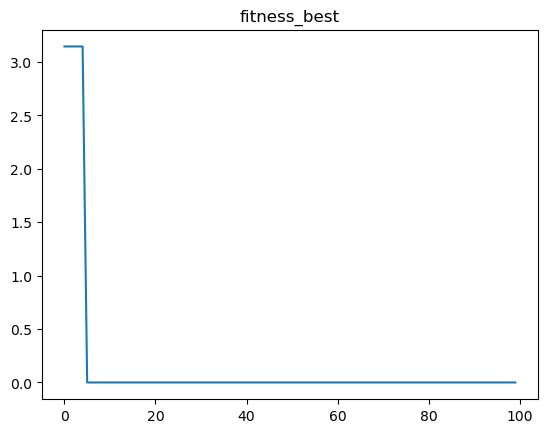

In [74]:
history = {
    "fitness_best": [],
}

population = init_population(N, 3, True)

for i in range(100):
    population = replicate(population, p_m)

    pred = perform_power_series_fn(population)
    targets = compute_targets(coeffs)

    fitness_vals = fitness(pred, targets)

    if entropy(population) < 1: selection(population, fitness_vals, int(endanger_pct*N))
    else: population = selection(population, fitness_vals, N)

    history["fitness_best"].append(fitness_vals.min().item())

print(population[:5])
for k, v in history.items():
    plt.figure()
    plt.title(k)
    plt.plot(v)

In [16]:
temp = np.array(history["fitness_best"])
np.argmin(temp[1:] - temp[:-1])

np.int64(0)

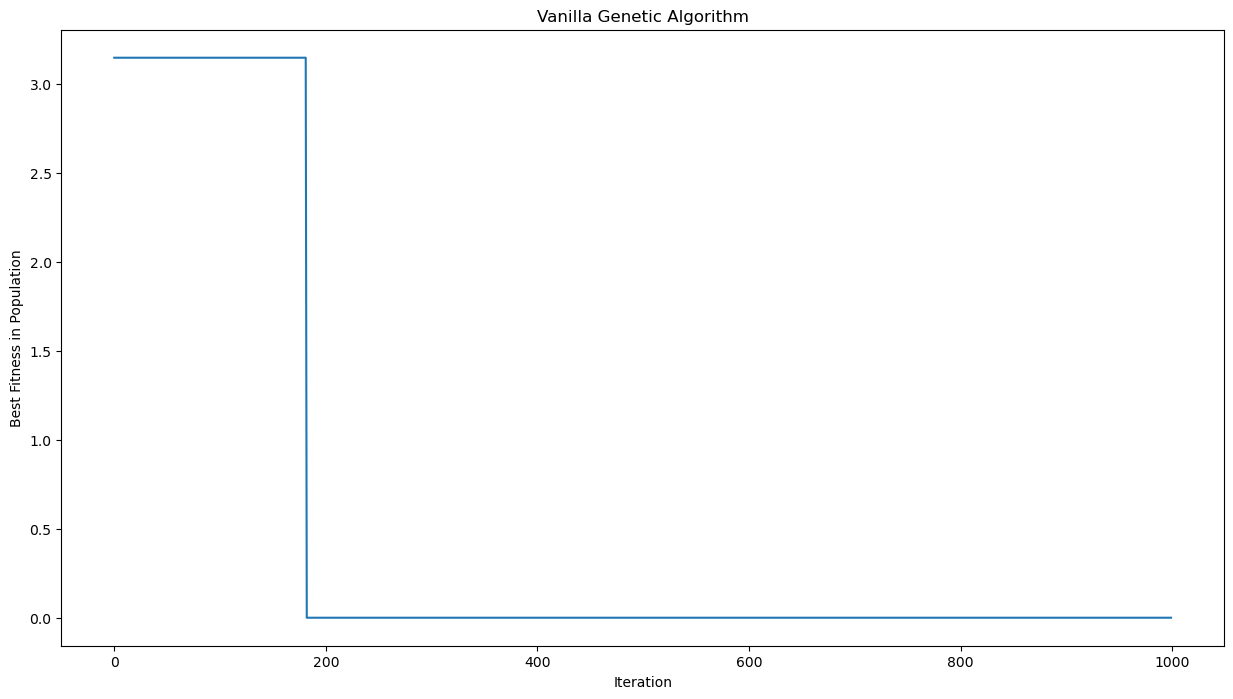

In [69]:
history = {
    "fitness_best": [],
}

population = init_population(N, 3, True)

for i in range(1000):
    population = replicate(population, p_m=0.01)

    pred = perform_power_series_fn(population)
    targets = compute_targets(coeffs)

    fitness_vals = fitness(pred, targets)

    population = selection(population, fitness_vals, N)

    history["fitness_best"].append(fitness_vals.min().item())


plt.figure(figsize=(15, 8))
plt.title("Vanilla Genetic Algorithm")
plt.xlabel("Iteration")
plt.ylabel("Best Fitness in Population")
plt.plot(history["fitness_best"])

64
(99, 151.5151515151515)


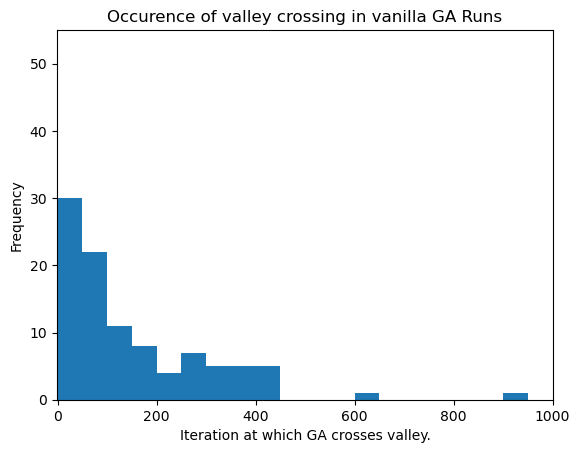

In [75]:
coeffs = (0, 0, 1)

p_m = 0.01
N = 64
endanger_every_n_gen = 5
endanger_pct = 0.5**0

print(int(endanger_pct*N))

valley_crossing_at = []
for exp in range(100):
    history = {
        "fitness_best": [],
    }

    population = init_population(N, 3, True)

    for i in range(1000):
        population = replicate(population, p_m)

        pred = perform_power_series_fn(population)
        targets = compute_targets(coeffs)

        fitness_vals = fitness(pred, targets)

        population = selection(population, fitness_vals, N)

        history["fitness_best"].append(fitness_vals.min().item())

    temp = np.array(history["fitness_best"])
    if not np.all(temp[1:] - temp[:-1] == 0):
        valley_crossing_at.append(np.argmin(temp[1:] - temp[:-1]).item())

plt.xlim(-1, 1001)
plt.ylim(0, 55)
print((len(valley_crossing_at), sum(valley_crossing_at)/len(valley_crossing_at)))
plt.title("Occurence of valley crossing in vanilla GA Runs")
plt.xlabel("Iteration at which GA crosses valley.")
plt.ylabel("Frequency")
plt.hist(valley_crossing_at, bins=20, range=(0, 1000))
plt.show()

In [78]:
66.06 / 148.3636

0.4452574620729074

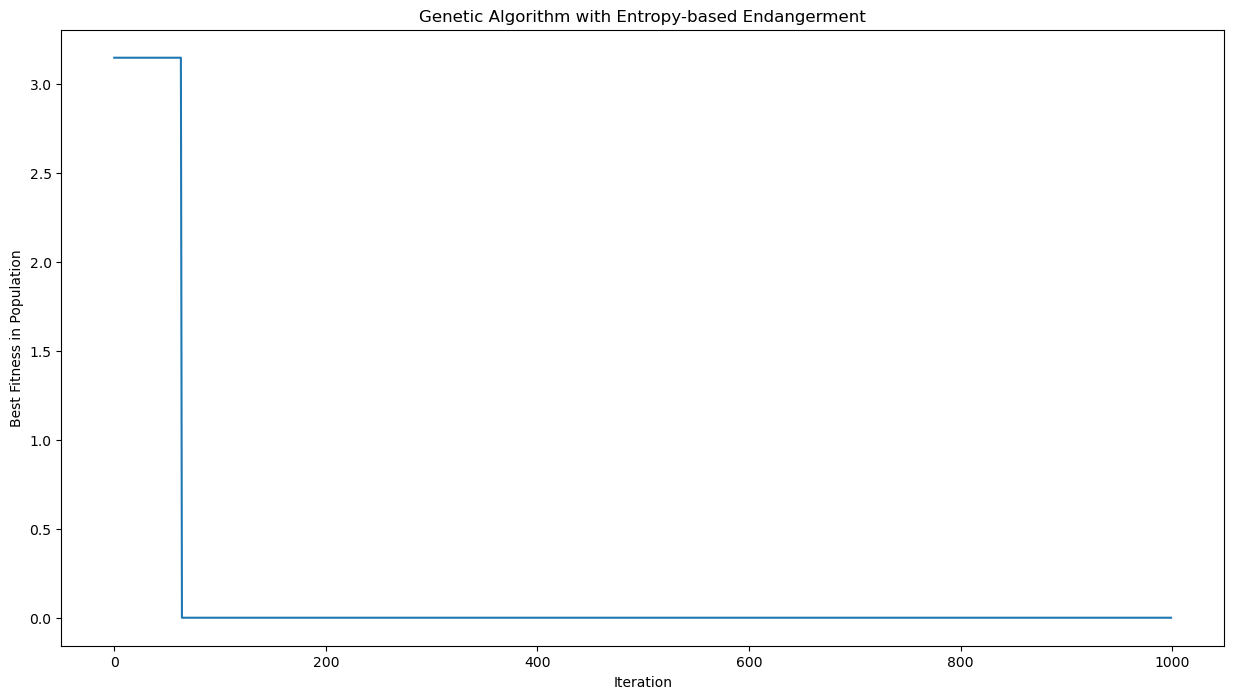

In [76]:
history = {
    "fitness_best": [],
}

population = init_population(N, 3, True)

for i in range(1000):
    population = replicate(population, p_m=0.01)

    pred = perform_power_series_fn(population)
    targets = compute_targets(coeffs)

    fitness_vals = fitness(pred, targets)

    if entropy(population) < 1:
        population = selection(population, fitness_vals, int(endanger_pct*N))
    else: population = selection(population, fitness_vals, N)

    history["fitness_best"].append(fitness_vals.min().item())


plt.figure(figsize=(15, 8))
plt.title("Genetic Algorithm with Entropy-based Endangerment")
plt.xlabel("Iteration")
plt.ylabel("Best Fitness in Population")
plt.plot(history["fitness_best"])

4
(100, 81.01)


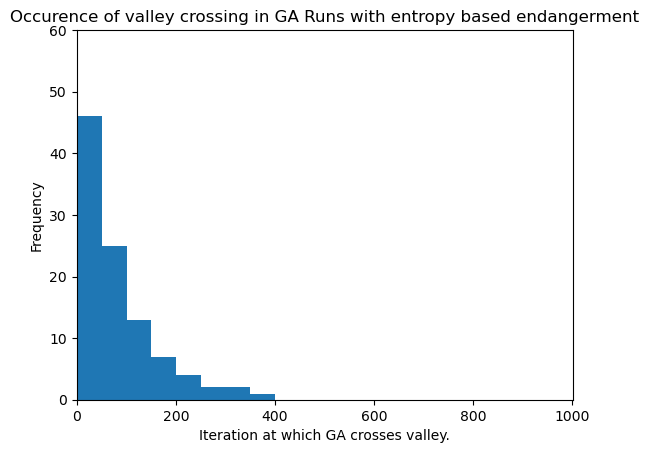

In [79]:

endanger_pct = 0.5**4
print(int(endanger_pct*N))

valley_crossing_at = []
for exp in range(100):
    history = {
        "fitness_best": [],
    }

    population = init_population(N, 3, True)

    for i in range(1000):
        while population.shape[0] <= N:
            population = replicate(population, p_m)

        pred = perform_power_series_fn(population)
        targets = compute_targets(coeffs)

        fitness_vals = fitness(pred, targets)

        if (i+1) % endanger_every_n_gen == 0 and entropy(population) < 1:
            population = selection(population, fitness_vals, int(endanger_pct*N))
        else: population = selection(population, fitness_vals, N)

        history["fitness_best"].append(fitness_vals.min().item())

    temp = np.array(history["fitness_best"])
    if not np.all(temp[1:] - temp[:-1] == 0):
        valley_crossing_at.append(np.argmin(temp[1:] - temp[:-1]).item())

plt.xlim(-1, 1001)
plt.ylim(0, 60)
print((len(valley_crossing_at), sum(valley_crossing_at)/len(valley_crossing_at)))
plt.title("Occurence of valley crossing in GA Runs with entropy based endangerment")
plt.xlabel("Iteration at which GA crosses valley.")
plt.ylabel("Frequency")
plt.hist(valley_crossing_at, bins=20, range=(0, 1000))
plt.show()

In [572]:
population

array([], shape=(0, 3), dtype=float64)

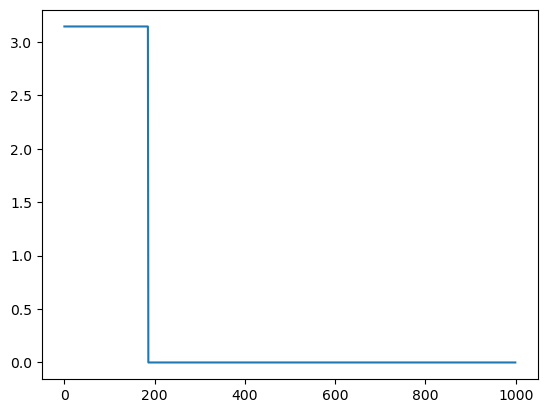

In [563]:
plt.plot(temp)

4


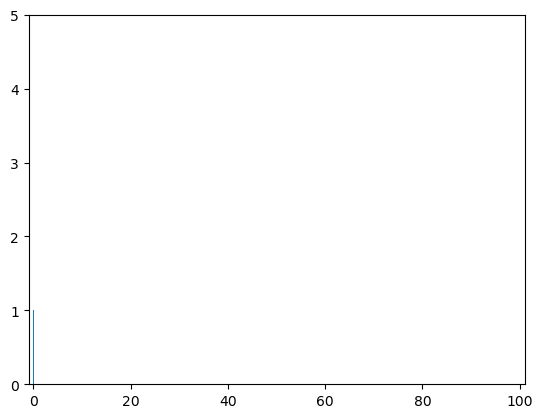

In [481]:
coeffs = (0, 0, 1)

p_m = 0.001
N = 32
endanger_every_n_gen = 5
endanger_pct = 0.5**3

print(int(endanger_pct*N))

valley_crossing_at = []
for exp in range(100):
    history = {
        "fitness_best": [],
    }

    population = init_population(N, 3, True)

    for i in range(100):
        population = replicate(population, p_m)

        pred = perform_power_series_fn(population)
        targets = compute_targets(coeffs)

        fitness_vals = fitness(pred, targets)

        if i == endanger_every_n_gen and entropy(population) < 1: selection(population, fitness_vals, int(endanger_pct*N))
        else: population = selection(population, fitness_vals, N)

        history["fitness_best"].append(fitness_vals.min().item())

    temp = np.array(history["fitness_best"])
    if not np.all(temp[1:] - temp[:-1] == 0):
        valley_crossing_at.append(np.argmin(temp[1:] - temp[:-1]).item())

plt.xlim(-1, 101)
plt.ylim(0, 5)
plt.hist(valley_crossing_at, bins=10)
plt.show()

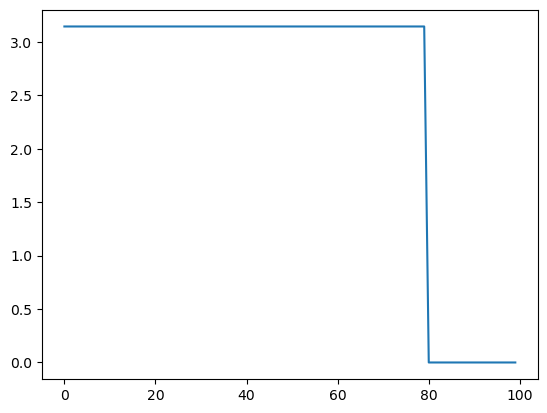

In [414]:
plt.plot(temp)

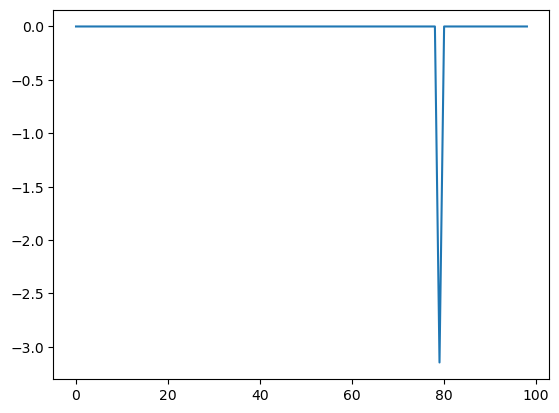

In [413]:
plt.plot(temp[1:] - temp[:-1])

In [ ]:
class Env:
    def __init__(self, population, coeffs):
        self.population = self.init(population)
        self.coeffs = coeffs

In [82]:
def guided_mutation(population, fitness_val, p_g=0.5, std=0.2):
    fitness_val_norm = 1 / (1 + fitness_val)
    fitness_val_norm = fitness_val_norm / fitness_val_norm.sum()
    weighted_avg = np.sum(population.T * fitness_val_norm, axis=1)
    delta = weighted_avg - population
    population = np.astype((population + delta * rng.normal(2 * p_g, std, size=population.shape[0]).reshape(-1, 1)) > 0.5, int)
    return population

fitness_val = fitness_fn(population)
population = guided_mutation(population, fitness_val)
population

NameError: name 'fitness_fn' is not defined

In [170]:
population = init_population(20, 5)
fitness_fn(population).sum()

np.float64(5495.1616587691515)

In [ ]:
env_coeffs = [(0, 0, 1)]
def ga(
    population,
    p_m,
    p_g,
    target_function,
    domain,
    samples_size,
    max_iter = 100
):
    fitness_fn = get_fitness_fn(target_function, domain, samples_size)
    history = {
        'fitness_avg': [],
        'fitness_best': [],
        'individual_best': [],
        'specific_information': []
    }

    fitness_val = fitness_fn(population )
    history['fitness_avg'].append(fitness_val.mean().item())
    history['fitness_best'].append(fitness_val.max().item())
    history['individual_best'].append(population[fitness_val.argmax()].tolist())

    for i in range(max_iter):
        population = mutate(population, p_m)
        population = guided_mutation(population, fitness_val, p_g)

        fitness_val = fitness_fn(population)
        history['fitness_avg'].append(fitness_val.mean().item())
        history['fitness_best'].append(fitness_val.min().item())
        history['individual_best'].append(population[fitness_val.argmax()].tolist())

    return history, population

In [221]:
N, M = 20, 5
p_m, p_g = 0.1, 1

target_function = lambda x: 1 + x**2 + x**3
domain = (-50, -20)
samples_size = 10

population = init_population(N, M)

history, population = ga(population, p_m, p_g, target_function, domain, samples_size, 100)
population

array([[1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0]])

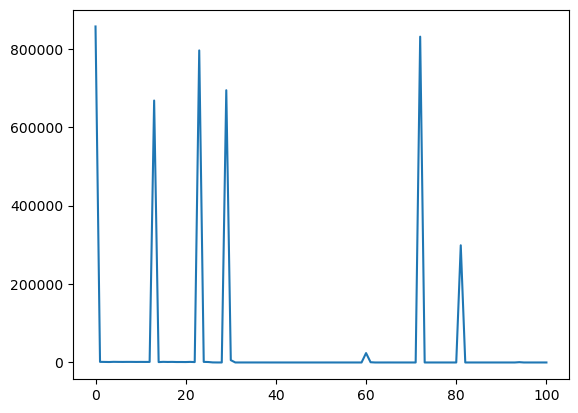

In [222]:
plt.plot(history['fitness_avg'])